In [36]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import manifold, datasets

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (silhouette_score, homogeneity_score, 
                             completeness_score, v_measure_score, 
                             pairwise_distances, f1_score)
from sklearn.cluster import (KMeans, AgglomerativeClustering)
from sklearn.model_selection import train_test_split

In [2]:
DATA_PATH = "data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [3]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [4]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(X[:, 0], X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

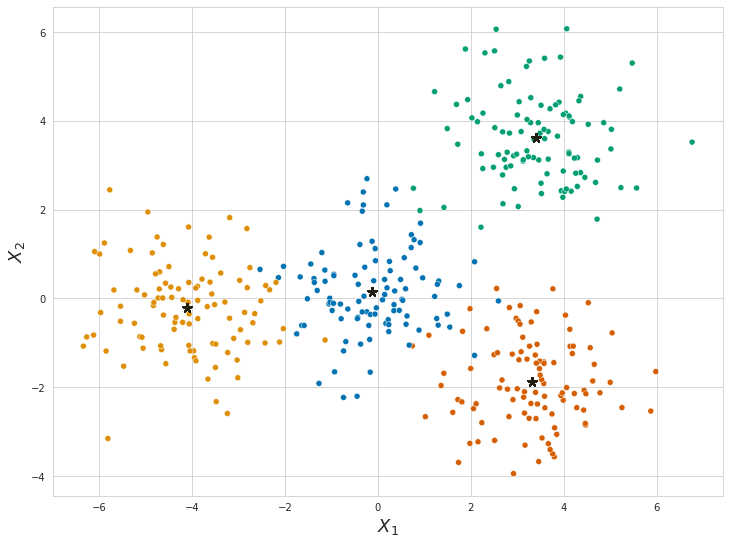

In [5]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуем методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [6]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        
        cluster_labels = []
        dists = []
        for centroid in self.centroids:
            dists.append(self._calculate_distance(X, centroid))
        dists = np.concatenate(dists, axis=1)
        cluster_labels = np.argmin(dists, axis=1)    
            
        return np.array(cluster_labels).reshape(-1,1)
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        dist = []
        for el in range(len(X)):
            dist.append(((X[el][0] - centroid[0])**2 + (X[el][1] - centroid[1])**2)**(0.5))
        return np.array(dist).reshape(-1,1)
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

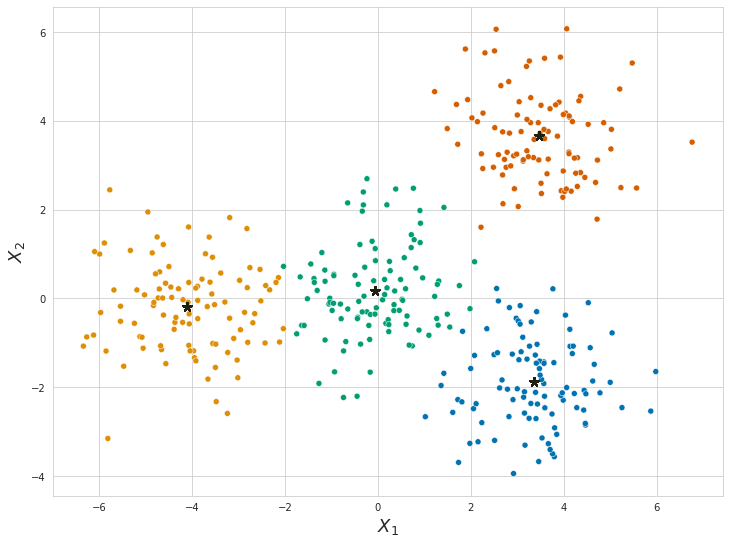

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [8]:
kmean = MyKMeans(4, visualize = True)
kmean.fit(X)

In [9]:
cluster_predict_1 = kmean.predict(X)

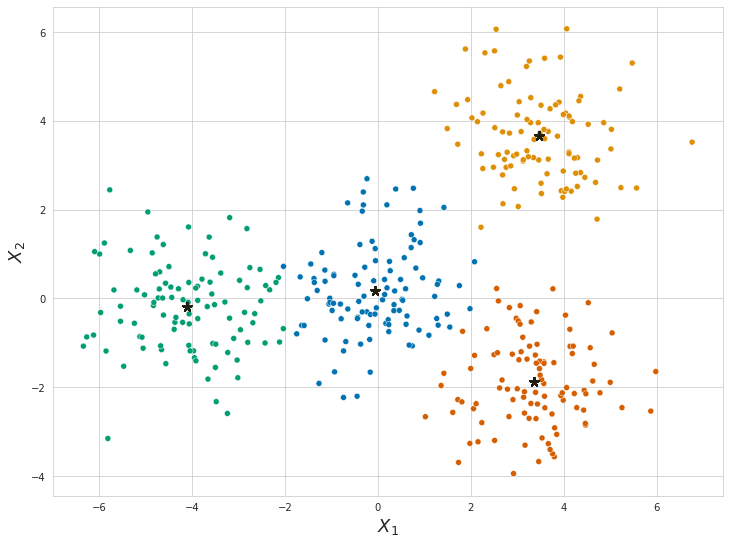

In [ ]:
kmean = MyKMeans(4, init="sample", visualize = True)
kmean.fit(X)

Забыла, что в конце, если всё хорошо, появится "мой KMeans". Подумала, что всё зависло. На самом деле, не вижу особой разницы в исходах кластеризации при разных способах инициализации центров кластеров (если судить по полученным картинкам). При втором способе KMeans работал дольше.

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [10]:
data = load_digits()
X, y = data.data, data.target

Посмотрим на картинки:

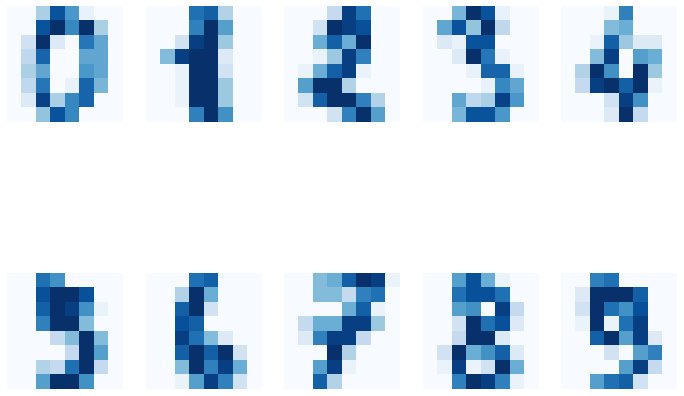

In [11]:
item = np.unique(y, return_counts=False)
indexes = list()
i = 0
for el in item:
    itemindex = np.where(y==el)
    indexes.append(itemindex[0][0])
for el in indexes:
    plt.subplot(2, 5, i + 1) 
    plt.imshow(X[el].reshape(8, 8, 1).astype(int), cmap="Blues")
    plt.axis("off")
    i += 1

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`). Укажите для каждого алгоритма число кластеров равное количеству классов в `y`.

##### YOUR TURN TO CODE

In [12]:
def algorithm_selection(X, distances, algorithms, metrics, y_true = None):
    
    '''
    distances = ["euclidean", "manhattan", "canberra", "braycurtis"]
    algorithms = ["average", "single", "complete"]
    metrics = ["Homogeneity", "Completeness", "V-measure", "Silhouette"]
    '''
    n_clusters = len(np.unique(y, return_counts=False))
    agl_clust = None
    column_names = ["Algorithm", "Distance"]
    for metric in metrics:
        column_names.append(metric)
    compare_dataframe = pd.DataFrame(columns = column_names)
    for alg in algorithms:
        for dist in distances:
            new_row = None
            agl_clust = AgglomerativeClustering(n_clusters, affinity=dist, linkage=alg).fit(X)
            y_pred = agl_clust.labels_
            H = C = V = S = None
            new_row = [alg, dist]
            for metric in metrics:
                if metric == "Homogeneity":
                    H = round(homogeneity_score(y_true, y_pred), 3)
                    new_row.append(H)
                elif metric == "Completeness":
                    C = round(completeness_score(y_true, y_pred), 3)
                    new_row.append(C)
                elif metric == "V-measure":
                    V = round(v_measure_score(y_true, y_pred), 3)
                    new_row.append(V)
                elif metric == "Silhouette":
                    S = round(silhouette_score(X, y_pred, metric=dist), 3)
                    new_row.append(S)
            compare_dataframe.loc[len(compare_dataframe)] = new_row
            
    
    return compare_dataframe

In [13]:
compare_table = algorithm_selection(X, ["euclidean", "manhattan", "canberra", "braycurtis"], ["average", "single", "complete"], ["Homogeneity", "Completeness", "V-measure", "Silhouette"], y_true=y)
compare_table

,Algorithm,Distance,Homogeneity,Completeness,V-measure,Silhouette
0,average,euclidean,0.655,0.782,0.713,0.147
1,average,manhattan,0.567,0.779,0.656,0.105
2,average,canberra,0.574,0.780,0.661,0.108
3,average,braycurtis,0.539,0.743,0.625,0.126
4,single,euclidean,0.005,0.274,0.010,-0.134
5,single,manhattan,0.005,0.276,0.010,-0.204
6,single,canberra,0.006,0.281,0.012,-0.158
7,single,braycurtis,0.005,0.273,0.010,-0.168
8,complete,euclidean,0.591,0.638,0.613,0.119
9,complete,manhattan,0.646,0.686,0.666,0.161


Гомогенность показывает, насколько каждый кластер состоит из объектов одного класса, а полнота — насколько объекты одного класса относятся к одному кластеру, V-мера объединяет в себе две эти величины. Метрики принимают значения в диапазоне $[0, 1]$, и большие значения соответствуют более точной кластеризации. Силуэт не предполагает знания истинных меток объектов, и позволяет оценить качество кластеризации, используя только саму (неразмеченную) выборку и результат кластеризации. Данная величина лежит в диапазоне $[-1, 1]$. Значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга.

Изобразим кластеры цифр для "наилучшего" и "наихудшего" варианта кластеризации (согласно величине метрик в полученной таблице). Каюсь, код не мой, я просто искала что-то, что поможет мне визуализировать не двумерный массив (до второй половины ДЗ я еще не добралась на тот момент).

In [14]:
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)
    plt.figure(figsize=(6, 4))
    for digit in np.unique(y, return_counts=False):
        plt.scatter(
            *X_red[y == digit].T,
            marker=f"${digit}$",
            s=50,
            c=plt.cm.nipy_spectral(labels[y == digit] / 10),
            alpha=0.5,
        )

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis("off")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

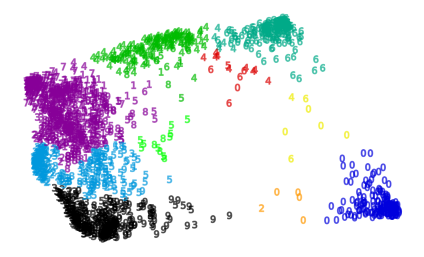

In [15]:
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
clustering = AgglomerativeClustering(linkage="average", affinity="euclidean", n_clusters=10)
clustering.fit(X_red)
plot_clustering(X_red, clustering.labels_)
plt.show()

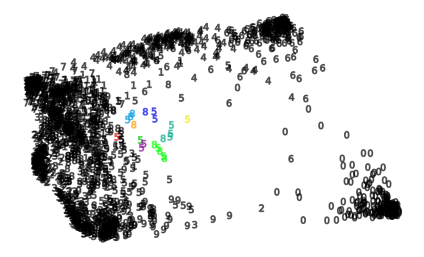

In [16]:
clustering = AgglomerativeClustering(linkage="single", affinity="braycurtis", n_clusters=10)
clustering.fit(X_red)
plot_clustering(X_red, clustering.labels_)
plt.show()

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [17]:
fc_data = pd.read_csv(join(DATA_PATH, "flow_c_data.csv"), index_col=0)

##### YOUR TURN TO CODE:

In [18]:
fc_data

,FSC-A,SSC-A,HLA-DR,CD3,CD45,CD14,CD56,CD19,CD11c
0,0.722199,0.154232,0.494449,0.512853,4.057328,1.019255,4.007273,-1.406912,0.384406
1,0.751073,0.114618,4.671924,0.822042,4.933149,0.159388,-0.216407,6.034845,0.577039
2,1.108188,0.150011,-0.422857,4.006353,5.616384,0.519223,0.783077,-0.318668,-0.493832
3,0.553310,0.119929,0.345968,3.332310,5.260935,1.481229,0.264846,0.694883,3.416960
4,0.774884,0.076984,4.984963,0.885501,4.562367,0.217117,0.086279,5.563345,0.471591
...,...,...,...,...,...,...,...,...,...
9995,1.180762,0.441445,2.437344,1.526085,4.455114,4.880495,0.347480,-0.591343,2.857737
9996,0.768279,0.111863,0.812236,4.254496,5.008437,1.303261,-0.130244,0.344169,-0.626795
9997,1.314964,0.233584,4.144130,1.311947,5.340263,1.598675,-0.287353,-0.887078,4.369294
9998,0.894135,0.137300,-0.226186,0.246804,4.430212,0.457881,2.404284,-0.112999,0.069239


Посмотрим на наши данные и узнаем, есть ли пропущенные значения с помощью describe(). 
В датасете - записи об интенсивности флуоресценции определенных маркеров (7 маркеров), сделанные для 10000 клеток. Пропущенных значений нет.
Таким образом, у нас 10000 наблюдений и 9 признаков.

In [19]:
fc_data.describe()

,FSC-A,SSC-A,HLA-DR,CD3,CD45,CD14,CD56,CD19,CD11c
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.962458,0.165415,1.791579,3.280391,5.169845,1.097182,0.412223,1.219683,0.569898
std,0.500012,0.190773,2.027281,2.112079,0.518247,1.375876,1.176967,2.285305,1.502445
min,0.144786,0.021657,-7.634172,-2.517639,-8.329666,-8.833883,-12.358701,-9.640775,-11.085437
25%,0.798804,0.105550,0.275056,1.401943,4.922227,0.389746,-0.195978,-0.146948,-0.498781
50%,0.908574,0.130543,1.194313,4.373660,5.234119,0.672853,0.053267,0.244121,0.272297
75%,1.052034,0.162536,3.696976,4.842212,5.481218,1.065076,0.378576,0.908374,1.220576
max,42.954485,15.460997,12.946668,13.844391,13.710922,6.294236,6.461899,7.208721,6.840864


Проверим, есть ли выбросы с помощью boxplot (хотя, судя по данным таблицы - они есть):

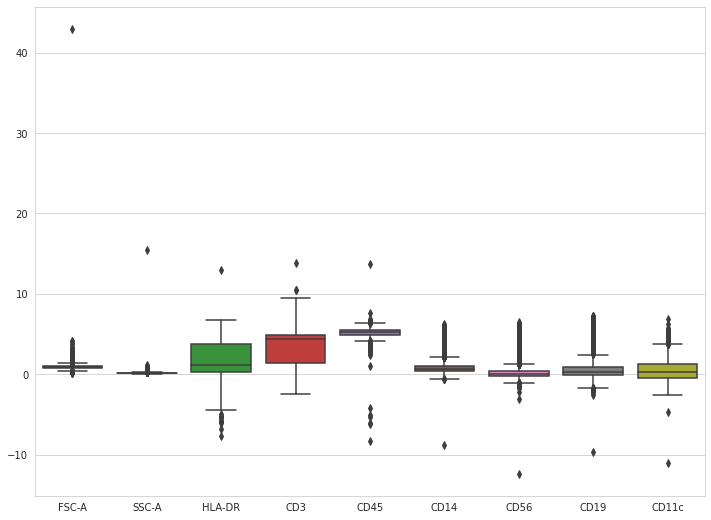

In [20]:
sns.boxplot(data=fc_data);

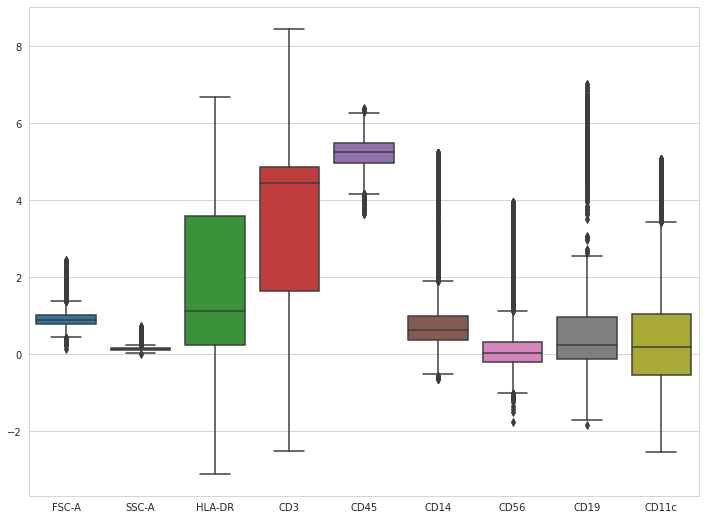

In [21]:
from scipy import stats
fc_data_wo_outliers = fc_data[(np.abs(stats.zscore(fc_data)) < 3).all(axis=1)]
sns.boxplot(data=fc_data_wo_outliers);

In [22]:
fc_data_wo_outliers.describe()

,FSC-A,SSC-A,HLA-DR,CD3,CD45,CD14,CD56,CD19,CD11c
count,9252.000000,9252.000000,9252.000000,9252.000000,9252.000000,9252.000000,9252.000000,9252.000000,9252.000000
mean,0.938499,0.146348,1.727069,3.445267,5.210249,0.900311,0.307474,1.301373,0.397107
std,0.237037,0.083685,2.000693,2.038509,0.388636,1.054097,0.995041,2.323849,1.321796
min,0.145234,0.021657,-3.091521,-2.517639,3.634335,-0.643408,-1.765140,-1.838961,-2.531130
25%,0.794827,0.103651,0.239004,1.642420,4.961559,0.371132,-0.206877,-0.127701,-0.540062
50%,0.900262,0.126933,1.131145,4.450008,5.260969,0.644707,0.033394,0.255412,0.185342
75%,1.031285,0.154339,3.580543,4.869985,5.492943,0.984130,0.327085,0.970715,1.047849
max,2.451654,0.733372,6.678981,8.445021,6.378036,5.223587,3.942214,7.003157,5.075853


После фильтрации потеряли 748 наблюдений (те наблюдения, у которых Z-score хотя бы одного признака превышал 3). 

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [23]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

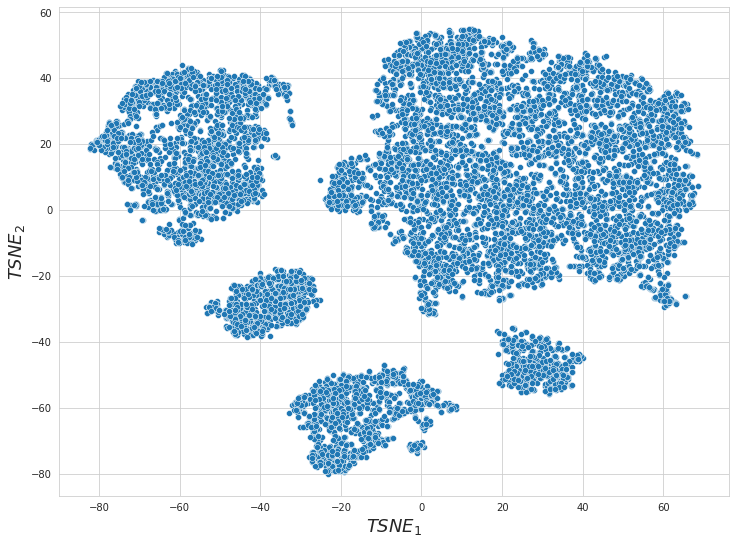

In [24]:
tsne_res = plot_tsne(fc_data)

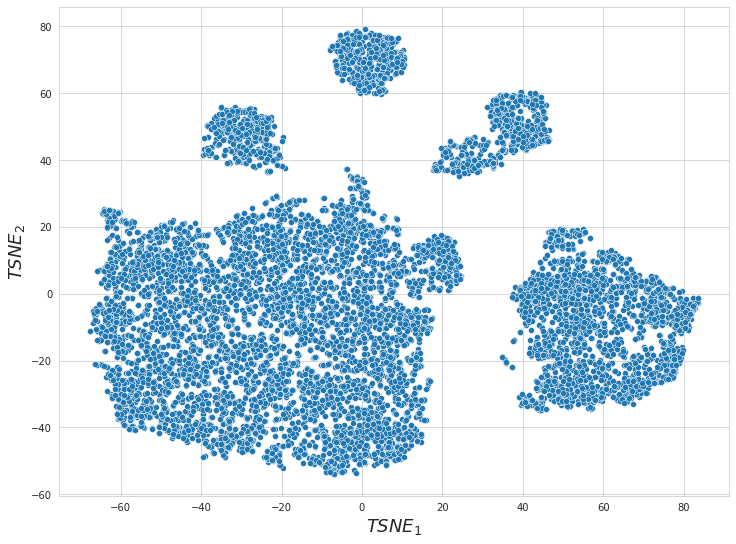

In [25]:
tsne_res = plot_tsne(fc_data_wo_outliers)

Визуально, сложно сказать, улучшило ли ситуацию удаление выбромов из датафрейма.

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

Воспользуемся нашей таблицей для сравнения:

In [26]:
compare_table = algorithm_selection(fc_data_wo_outliers, ["euclidean", "manhattan", "canberra", "braycurtis"], ["average", "single", "complete"], ["Silhouette"])
compare_table

,Algorithm,Distance,Silhouette
0,average,euclidean,0.493
1,average,manhattan,0.483
2,average,canberra,0.136
3,average,braycurtis,0.369
4,single,euclidean,0.432
5,single,manhattan,0.317
6,single,canberra,-0.029
7,single,braycurtis,-0.045
8,complete,euclidean,0.178
9,complete,manhattan,0.391


Выберем linkage = "average" и евклидово расстояние:

In [27]:
clustering = AgglomerativeClustering(linkage="average", affinity="euclidean", n_clusters=5)
clustering.fit(fc_data_wo_outliers)
cluster_predict = clustering.labels_

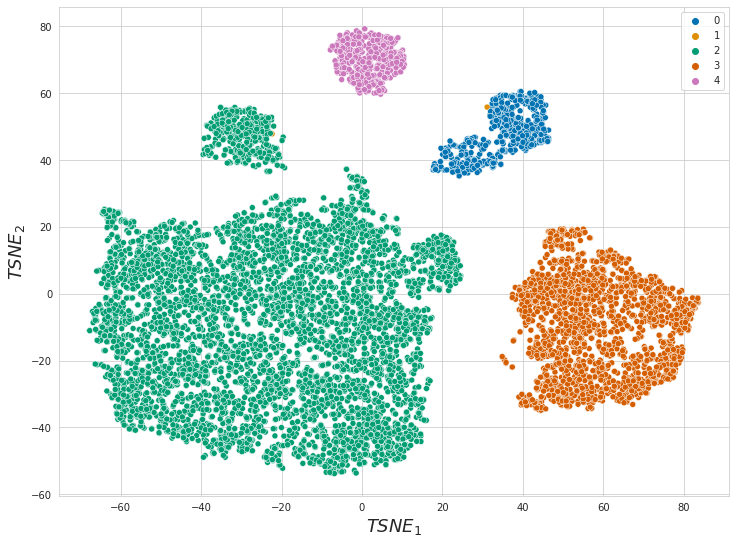

In [28]:
tsne_res = plot_tsne(fc_data_wo_outliers, color=cluster_predict)

2 кластера оказались окрашены в один цвет. Плюс, есть еще две точки (по легенде - кластер "2"), которые не образуют кластер между собой. И тут я затрудняюсь, как поступить дальше. Могу ли я удалить это данные из таблицы и пересчитать? Потому что типов у нас только 4. Или я должна проаннотировать не 4 типа клеток, а 5, а потом найти эти строки и заменить значение в последнем столбце на тот клеточный тип, который ссответствует кластеру на рисунке? Или просто их не аннотировать?\
Наверно, я оставлю эти две клетки без аннотации и затем удалю из таблицы наблюдения, которые им соотвествуют.

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

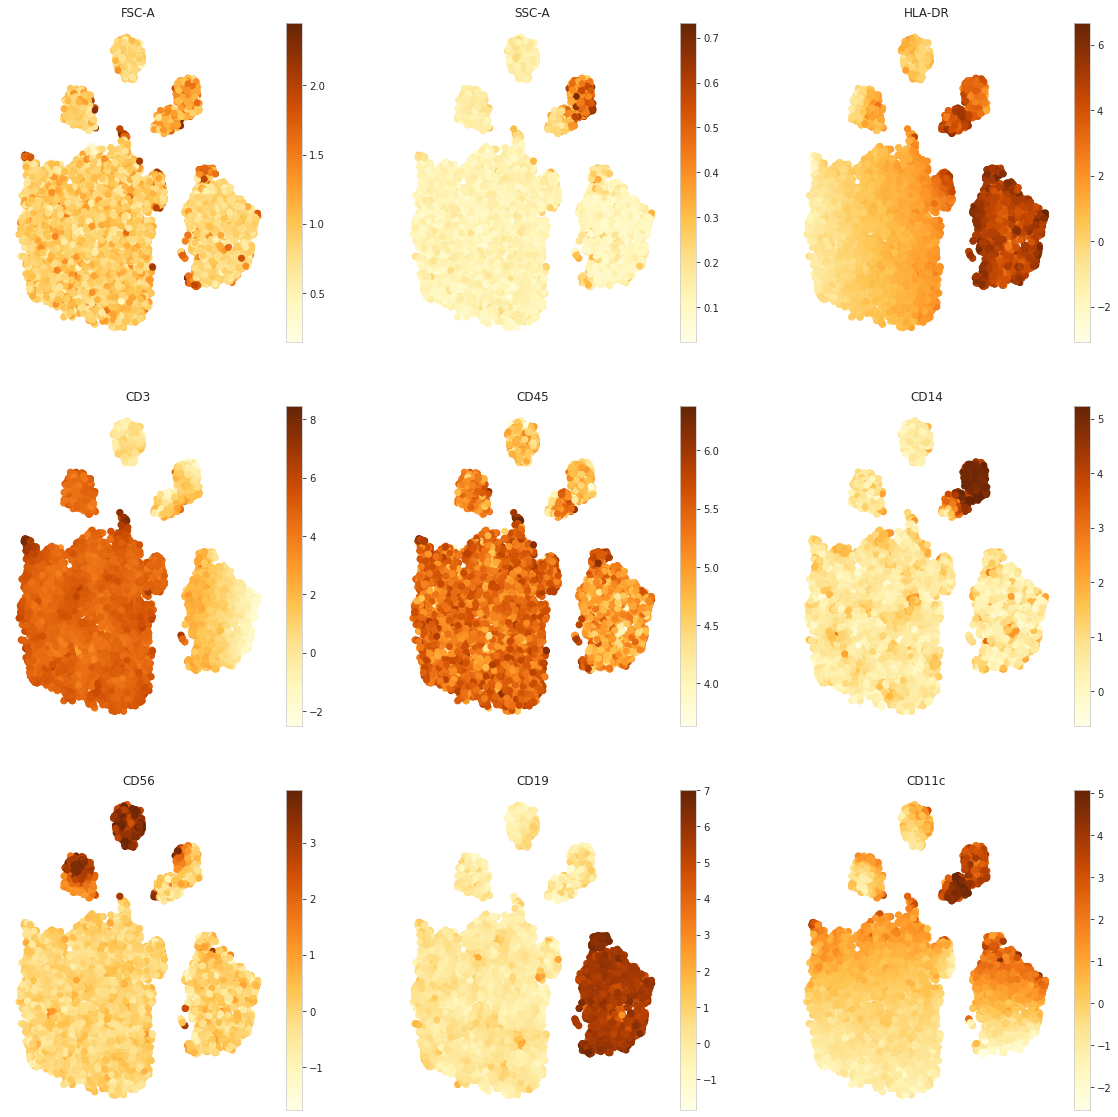

In [29]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data_wo_outliers.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data_wo_outliers[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Сильнее всего "бросается в глаза" экспрессия следующих маркеров: CD19+ (В-клетки), CD14+ (моноциты), CD3+ (T-клетки). Молекулы HLA-DR экспрессируются на поверхности макрофагов, B-клеток и дендритных клеток. Маркер CD45 - общий лейкоцитарный антиген - экспрессируется на T- и B-клетках, моноцитах и гранулоцитах. Маркер CD11c экспрессируется на мембране моноцитов, гранулоцитов, В-клеток и макрофагов. CD56 является маркёром естественных киллеров, а также присутствует на CD4+ и CD8+ T-лимфоцитах.

Параметр "FSC" - прямое светорассеяние (рассеяние света под малым углом) позволяет определить относительный размер клеток или частиц. Здесь все клетки примерно одикановы, кроме кластера "0" (предполагаемые моноциты). На мой взгляд, клетки этого кластера чуть "темнее".

Параметр "SSC" - боковое светорассеяние (рассеяние света под прямым углом) - используется для оценки неоднородности внутриклеточного содержимого клетки (например, размера ядра и гранулярности цитоплазмы). Наиболее темные клетки - опять же, вероятно, моноциты (поскольку размер их ядер - наибольший среди ядер клеток крови).

In [30]:
cell_type_cluster_map = {0: "Monocytes", 
                         2: "T_cells", 
                         3: "B_cells", 
                         4: "Other_cells"}

In [31]:
labeled_fc_data = fc_data_wo_outliers.assign(Population=cluster_predict)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Посчитайте, как распределены типы клеток:

In [32]:
labeled_fc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9252 entries, 1 to 9999
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   FSC-A       9252 non-null   float64
 1   SSC-A       9252 non-null   float64
 2   HLA-DR      9252 non-null   float64
 3   CD3         9252 non-null   float64
 4   CD45        9252 non-null   float64
 5   CD14        9252 non-null   float64
 6   CD56        9252 non-null   float64
 7   CD19        9252 non-null   float64
 8   CD11c       9252 non-null   float64
 9   Population  9250 non-null   object 
dtypes: float64(9), object(1)
memory usage: 795.1+ KB


Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

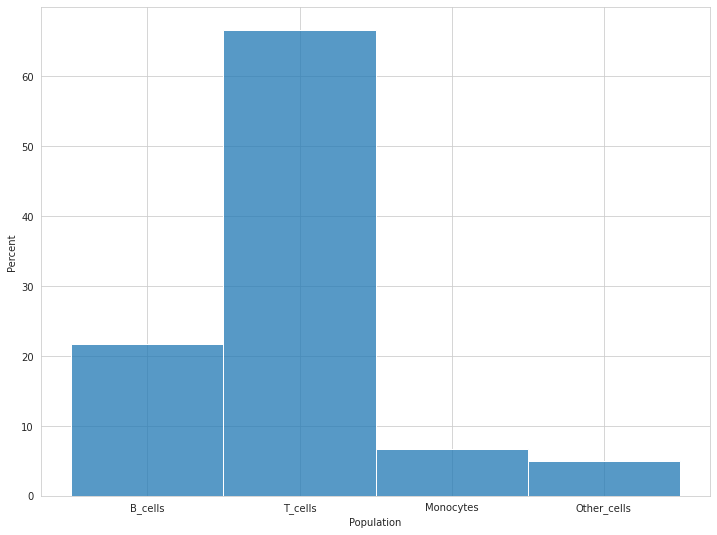

In [33]:
labeled_fc_data = labeled_fc_data.dropna()
sns.histplot(data=labeled_fc_data["Population"], stat="percent");

Теперь можно сделать несколько предположений:\
    а) я неправильно классифицировала клетки (потому что в норме нейтрофилов (а, значит, "других клеток") должно быть больше)\
    б) человеку плохо (если это человек) - это явный лимфоцитоз

Сохраним полученную таблицу в отдельный файл:

In [37]:
labeled_fc_data.to_csv("labeled_fc_data.txt", sep="\t", index=False)

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

Была мысль попробовать KNN, логистическую регрессию и KMeans (вроде у него тоже есть predict). 

In [38]:
X = labeled_fc_data.iloc[: , :-1].to_numpy()
y = labeled_fc_data["Population"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=SEED)

In [39]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X_train)
y_pred = kmeans.predict(X_test)
new_y_pred = []
for el in y_pred:
    if el == 0:
        new_y_pred.append("B_cells")
    if el == 1:
        new_y_pred.append("T_cells")
    if el == 2:
        new_y_pred.append("Other_cells")
    if el == 3:
        new_y_pred.append("Monocytes")
new_y_pred = np.array(new_y_pred)

In [40]:
f1_score(y_test, new_y_pred, average='macro')

0.5

Попробуем логистическую регресисю:

In [41]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [42]:
f1_score(y_test, y_pred, average='macro')

1.0

У сожалению, не успеваю разобраться до конца с этим заданием, понять, почему такой результат у f1_score и почитать про дисбаланс классов (одной ногой в дедлайне). Если будет время, постараюсь во время работы над ошибками исправить.

### Задание 4. Любимое место

Всегда хотела в Норвегию. Пандемия сказала, что она против, и я осталась дома из-за закрытых границ, хотя билеты уже были на руках.

вот вам печальный анекдот на эту тему:

-Я опять хочу в Норвегию...\
-А что, Вы там когда-то были?\
-Нет, я уже когда-то хотел

<img src="https://img5.goodfon.com/original/1920x1080/5/a3/reine-nordland-fylke-norge.jpg" width="1024" height="668">

### Therapy time

На этой неделе было сложно, грустно и больно, и, к сожалению, совсем не из-за заданий по ML. Всем мира.

<img src="https://images-na.ssl-images-amazon.com/images/I/61DCxVe0y9L.jpg" width="276" height="340">